# 1. Resolver as dependências

In [1]:
!pip install tensorflow keras keras-rl2 gym gym[atari] ale-py

# 2. Setup

In [2]:
import gym
import ale_py
from random import randrange
import numpy as np

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from tensorflow import keras
from keras import layers

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, SoftmaxPolicy, EpsGreedyQPolicy
from rl.policy import GreedyQPolicy, BoltzmannQPolicy, MaxBoltzmannQPolicy, BoltzmannGumbelQPolicy
from rl.memory import SequentialMemory

C:\Users\thiag\anaconda3\envs\new_env\lib\site-packages\ale_py\roms\__init__.py:94: DeprecationWarning: Automatic importing of atari-py roms won't be supported in future releases of ale-py. Please migrate over to using `ale-import-roms` OR an ALE-supported ROM package. To make this warning disappear you can run `ale-import-roms --import-from-pkg atari_py.atari_roms`.For more information see: https://github.com/mgbellemare/Arcade-Learning-Environment#rom-management
  _RESOLVED_ROMS = _resolve_roms()


In [3]:
print('gym:', gym.__version__)
print('ale_py:', ale_py.__version__)
print('numpy:', np.__version__)
print('tensorflow:', tf.__version__)
print('keras:', keras.__version__)

gym: 0.21.0
ale_py: 0.7.3
numpy: 1.21.2
tensorflow: 2.5.0
keras: 2.5.0


In [4]:
#Basicamente precisamos dar acesso a memória RAM para conseguir processar
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

Obtêm as Roms

In [6]:
!curl -O "http://www.atarimania.com/roms/Roms.rar"
!tar -xzvf lfw.tgz
!mkdir rars
!mv HC\ ROMS.zip   rars
!mv ROMS.zip  rars
!python -m atari_py.import_roms rars

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 10.6M    0 24551    0     0  17531      0  0:10:34  0:00:01  0:10:33 17536
  1 10.6M    1  133k    0     0  53847      0  0:03:26  0:00:02  0:03:24 53838
  2 10.6M    2  324k    0     0  96012      0  0:01:55  0:00:03  0:01:52 96026
  5 10.6M    5  647k    0     0   140k      0  0:01:17  0:00:04  0:01:13  140k
  8 10.6M    8  901k    0     0   163k      0  0:01:06  0:00:05  0:01:01  178k
 10 10.6M   10 1153k    0     0   178k      0  0:01:00  0:00:06  0:00:54  222k
 13 10.6M   13 1473k    0     0   193k      0  0:00:56  0:00:07  0:00:49  264k
 15 10.6M   15 1730k    0     0   202k      0  0:00:53  0:00:08  0:00:45  275k
 18 10.6M   18 1986k    0     0   207k      0  0:00

copying adventure.bin from rars\Adventure (1980) (Atari, Warren Robinett) (CX2613, CX2613P) (PAL).bin to C:\Users\thiag\anaconda3\envs\new_env\lib\site-packages\atari_py\atari_roms\adventure.bin
copying air_raid.bin from rars\Air Raid (Men-A-Vision) (PAL) ~.bin to C:\Users\thiag\anaconda3\envs\new_env\lib\site-packages\atari_py\atari_roms\air_raid.bin
copying alien.bin from rars\Alien (1982) (20th Century Fox Video Games, Douglas 'Dallas North' Neubauer) (11006) ~.bin to C:\Users\thiag\anaconda3\envs\new_env\lib\site-packages\atari_py\atari_roms\alien.bin
copying amidar.bin from rars\Amidar (1982) (Parker Brothers, Ed Temple) (PB5310) ~.bin to C:\Users\thiag\anaconda3\envs\new_env\lib\site-packages\atari_py\atari_roms\amidar.bin
copying assault.bin from rars\Assault (AKA Sky Alien) (1983) (Bomb - Onbase) (CA281).bin to C:\Users\thiag\anaconda3\envs\new_env\lib\site-packages\atari_py\atari_roms\assault.bin
copying asterix.bin from rars\Asterix (AKA Taz) (07-27-1983) (Atari, Jerome Domur

Traceback (most recent call last):
  File "C:\Users\thiag\anaconda3\envs\new_env\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\thiag\anaconda3\envs\new_env\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\thiag\anaconda3\envs\new_env\lib\site-packages\atari_py\import_roms.py", line 93, in <module>
    main()
  File "C:\Users\thiag\anaconda3\envs\new_env\lib\site-packages\atari_py\import_roms.py", line 89, in main
    import_roms(args.dirpath)
  File "C:\Users\thiag\anaconda3\envs\new_env\lib\site-packages\atari_py\import_roms.py", line 74, in import_roms
    with open(filepath, "rb") as f:
FileNotFoundError: [Errno 2] No such file or directory: 'rars\\Pursuit of the Pink Panther (Pink Panther - The Video Game, Adventures of the Pink Panther) (1983) (Probe 2000 - NAP, Roger Booth, Todd Marshall, Robin McDaniel, Jim Wickstead) (3152VC) (Prototype) ~.bin'


In [7]:
ENV_NAME = 'MsPacman-ram-v0'

In [8]:
env = gym.make(ENV_NAME)

In [9]:
env.unwrapped.get_action_meanings()

['NOOP',
 'UP',
 'RIGHT',
 'LEFT',
 'DOWN',
 'UPRIGHT',
 'UPLEFT',
 'DOWNRIGHT',
 'DOWNLEFT']

In [10]:
# Para facilitar removemos as ações: UPRIGHT, UPLEFT, DOWNRIGHT e DOWNLEFT
actions = env.action_space.n - 4

Episode:2 Score:170.0


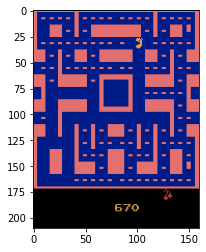

In [11]:
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
episodes = 2
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0

    while not done:
        img.set_data(env.render(mode='rgb_array'))
        display.display(plt.gcf())
        display.clear_output(wait=True)
        action = randrange(actions)
        n_state, reward, done, info = env.step(action)
        score+=reward
        env.step(action)
        env.step(action)
    print('Episode:{} Score:{}'.format(episode, score))
        
env.close()

In [15]:
seed = 123
np.random.seed(seed)
env.seed(seed)
max_steps_per_episode = 150000

# 3. Cria Deep Learning Model com Keras

In [16]:
def build_model(env, actions):
    model = keras.Sequential()
    model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [17]:
model = build_model(env, actions)

# 4. Cria Agent com Keras-RL

In [18]:
def build_agent(model, actions):
    policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1.,
                                  value_min=.1, value_test=.05,
                                  nb_steps=max_steps_per_episode)
    
    memory = SequentialMemory(limit=5000, window_length=1)

    dqn = DQNAgent(model=model,
                   memory=memory,
                   policy=policy,
                   nb_actions=actions,
                   nb_steps_warmup=50000,
                   target_model_update=10000,
                   gamma=.99,
                   train_interval=4,
                   delta_clip=1.)
    return dqn

In [19]:
dqn = build_agent(model, actions)

In [20]:
dqn.compile(Adam(learning_rate=.00025), metrics=['mae'])

# 5. Treina 

In [21]:
dqn.fit(env, nb_steps=max_steps_per_episode, visualize=False, verbose=1)

Training for 150000 steps ...
Interval 1 (0 steps performed)


C:\Users\thiag\anaconda3\envs\new_env\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


10000/10000 [==============================] - 25s 2ms/step - reward: 0.3050
15 episodes - episode_reward: 192.000 [110.000, 430.000] - lives: 2.072

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 24s 2ms/step - reward: 0.3550
17 episodes - episode_reward: 208.235 [120.000, 580.000] - lives: 2.063

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 23s 2ms/step - reward: 0.3140
17 episodes - episode_reward: 187.647 [110.000, 480.000] - lives: 2.087

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 25s 3ms/step - reward: 0.3740
17 episodes - episode_reward: 222.353 [100.000, 500.000] - lives: 2.081

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 25s 2ms/step - reward: 0.3310: 0
15 episodes - episode_reward: 218.667 [90.000, 330.000] - lives: 2.122

Interval 6 (50000 steps performed)
10000/10000 [==============================] - 67s 7ms/step - reward: 0.4

# 6. Preserva dados do Treino

In [22]:
dqn.save_weights('dqn_{}_weights.h5f'.format(ENV_NAME), overwrite=True)

In [23]:
scores = dqn.test(env, nb_episodes=10, visualize=False)
print(np.mean(scores.history['episode_reward']))

Testing for 10 episodes ...
Episode 1: reward: 140.000, steps: 708
Episode 2: reward: 220.000, steps: 669
Episode 3: reward: 140.000, steps: 685
Episode 4: reward: 140.000, steps: 699
Episode 5: reward: 180.000, steps: 698
Episode 6: reward: 140.000, steps: 693
Episode 7: reward: 240.000, steps: 774
Episode 8: reward: 300.000, steps: 729
Episode 9: reward: 140.000, steps: 694
Episode 10: reward: 180.000, steps: 705
182.0


# 7. Recarrega dados do Treino na Memória

In [24]:
del model
del dqn
del env

In [25]:
env = gym.make(ENV_NAME)
actions = env.action_space.n - 4
states = env.observation_space.shape[0]
model = build_model(env, actions)
dqn = build_agent(model, actions)
dqn.compile(Adam(learning_rate=.00025), metrics=['mae'])

In [26]:
dqn.load_weights('dqn_{}_weights.h5f'.format(ENV_NAME))

In [27]:
_ = dqn.test(env, nb_episodes=10, visualize=True)
env.close()

Testing for 10 episodes ...


C:\Users\thiag\anaconda3\envs\new_env\lib\site-packages\gym\envs\atari\environment.py:255: UserWarning: WARN: We strongly suggest supplying `render_mode` when constructing your environment, e.g., gym.make(ID, render_mode='human'). Using `render_mode` provides access to proper scaling, audio support, and proper framerates.
  logger.warn(
C:\Users\thiag\anaconda3\envs\new_env\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Não é possível alterar o modo de thread depois de o mesmo estar definido
  warnings.warn(str(err))


Episode 1: reward: 370.000, steps: 1153
Episode 2: reward: 140.000, steps: 698
Episode 3: reward: 190.000, steps: 693
Episode 4: reward: 140.000, steps: 693
Episode 5: reward: 140.000, steps: 702
Episode 6: reward: 140.000, steps: 689
Episode 7: reward: 170.000, steps: 756
Episode 8: reward: 170.000, steps: 697
Episode 9: reward: 290.000, steps: 696
Episode 10: reward: 140.000, steps: 687


# Claramente precisa aumentar e muito o max_steps_per_episode para conseguir fazer com que o Agente consiga jogar como um ser humano